# 심화학습

## K-평균 군집화
- 레이블이 없는 다차원 데이터 세트 내에 사전 정의된 군집의 개수를 찾아낸다.
  - K 평균 모델의 가정
    1. 군집 중앙은 해당 군집에 속하는 모든 점의 **산술 평균**이다.
    2. 각 점은 다른 군집의 중앙보다 **자신이 속한** 군집의 중앙에 더 가깝다,

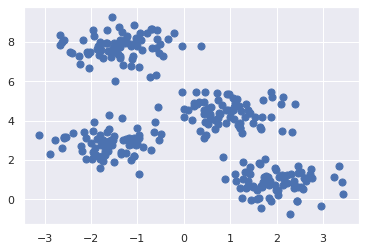

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # 플롯 스타일 지정
import numpy as np
from sklearn.datasets.samples_generator import make_blobs #  등방성 가우시안 정규분포를 이용해 가상 데이터를 생성
from sklearn.cluster import KMeans

X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0) # centers : 생성할 클러스터의 수 혹은 중심 / cluster_std: 클러스터의 표준 편차, 디폴트 1.0
plt.scatter(X[:, 0], X[:, 1], s=50)

# 위 두 줄과 같은 내용
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

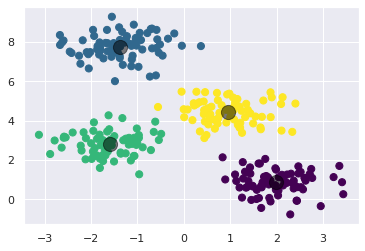

In [17]:
plt.scatter(X[:, 0], X[:, 1], s=50, c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

# K-평균 알고리즘 : 기댓값 - 최대화
- k-평균에 접근하는 일반적인 방식 : 기댓값 - 최대화 
- 데이터 과학에서 다양한 상황에 사용되는 강력한 알고리즘이다
- 기댓값 - 최대화 단계
  1. 일부 군집 중심을 추측
  2. 수렴될 때까지 다음을 반복
    2-1. E-단계 : 점을 가장 가까운 군집 중심에 할당
    2-2. M-단계 : 군집 중심을 평균값에 설정

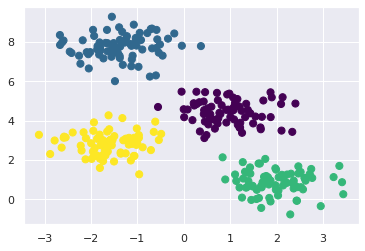

In [25]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_cluster, rseed=2):
  # 임의로 군집 선택
  rng = np.random.RandomState(rseed)
  i = rng.permutation(X.shape[0])[:n_cluster]
  centers=X[i]

  while True:
    # 가장 가까운 중심을 기반으로 레이블 할당
    labels = pairwise_distances_argmin(X, centers)
    # 점들의 평균으로부터 새로운 군집 발견
    new_centers = np.array([X[labels==i].mean(0) for i in range(n_cluster)])
    # 수렴 여부 검사
    if np.all(centers == new_centers):
      break
    centers = new_centers

  return centers, labels

centers, labels = find_clusters(X,4)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis')

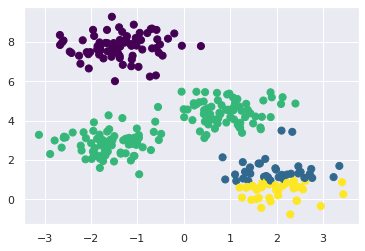

In [33]:
# 만족스럽지 못한 결과ver
centers, labels = find_clusters(X,4, rseed=0)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis')

# K-평균은 선형 군집 경계로 한정된다
- SpectralClustering : 커널 변환 방식을 사용하면 비선형 경계를 구할 수 있다. 

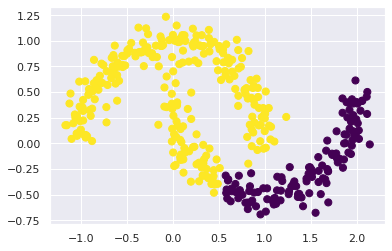

In [46]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis')

# 왜 비선형으로 안나누어질까? - 책과는 다른 답이 나옴

# t-SNE
- 군집 내의 점을 보존하는데 능숙한 비선형 임베딩 알고리즘

In [51]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from scipy.stats import mode

digits = load_digits()

from sklearn.manifold import TSNE
# 데이터 사영
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# 군집계산
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)

# 레이블 바꾸기
labels = np.zeros_like(clusters)
for i in range(10):
  mask= (clusters == i)
  labels[mask] = mode(digits.target[mask])[0]

# 정확도 계산
# 레이블을 사용하지 않고 약 80%의 분류 정확도를 보여준다
accuracy_score(digits.target, labels)

0.7952142459654981

# 가우스 혼합 모델(GMM)
- k-평균의 약점을 보완하고자 나온 모델
- k-평균 모델에는 군집 할당의 확률이나 불확실설에 대한 고유 척도가 없다
- GMM에는 내부적으로 확률 모델을 포함하기 떄문에 확률적으로 군집을 할당하는 것도 가능하다.

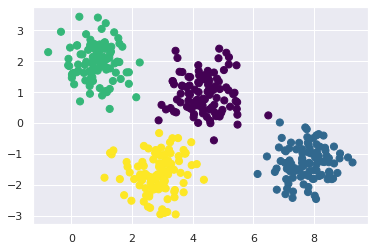

In [64]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis')

In [66]:
# 특정 군집에 속한 모든 점들의 확률을 측정한 크기가 [n_samples, n_clusters]인 행렬을 반환
probs = gmm.predict_proba(X) 
print(probs[:5].round(3))

[[0.537 0.463 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


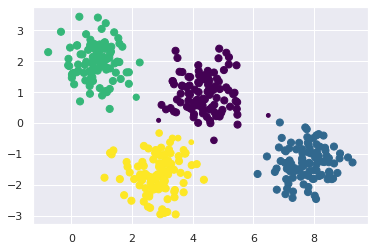

In [68]:
size = 50 * probs.max(1) ** 2 # 제곱으로 차이를 강조
plt.scatter(X[:,0], X[:,1], c=labels, s=size, cmap='viridis')

In [85]:
# GMM 결과 기반으로 한 타원형 그리기

from matplotlib.patches import Ellipse
# **kwarge : 키워드 = 특정값 형태로 함수 호출
def draw_ellipse(position, covariance, ax=None, **kwargs): 
  ax = ax or plt.gca()
  # 공분산을 주축으로 전환
  if covariance.shape == (2,2):
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
    width, height = 2 * np.sqrt(s)
  else : 
    angel = 0
    width, height = 2 * np.sqrt(covariance)

   # 타원 그리기
  for nsig in range(1, 4):
     ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
  ax = ax or plt.gca()
  labels = gmm.fit(X).predict(X)
  if label:
    ax.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis', zorder=2)
  else :
    ax.scatter(X[:,0], X[:,1], c=labels, s=size, zorder=2)
  ax.axis('equal')
  w_factor = 0.2 / gmm.weights_.max()
  for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)

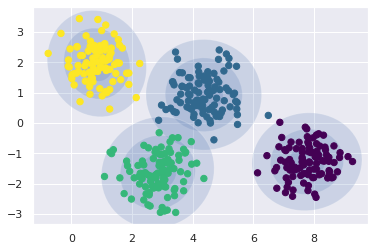

In [86]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

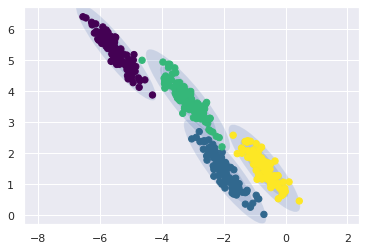

In [91]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2,2))

gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

# 공분산 유형 선택(covariance_type =)
- 기본값 : 'diag' (약간 타원)
- 약간 더 빠른 모델 : 'spherical' (원형)
- 복잡하고 계산 비용이 높은 모델 : 'full' (타원)

In [94]:
# GMM을 사용해 새로운 손글씨 숫자데이터를 생성
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape
# 약 1800개에 달하는 64차원의 숫자 데이터를 가지고 있다.

(1797, 64)

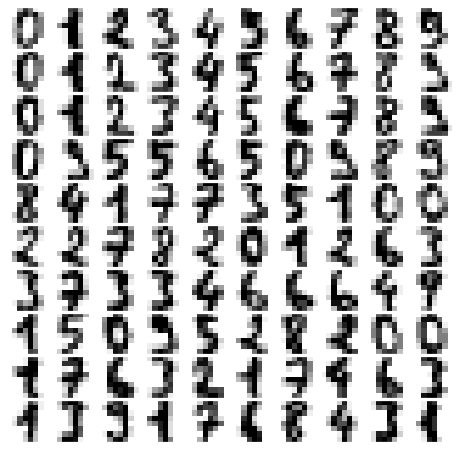

In [102]:
def plot_digits(data):
  fig, ax = plt.subplots(10, 10, figsize=(8,8), subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
    im = axi.imshow(data[i].reshape(8,8), cmap='binary') # binary : 흰 -> 검 / 검 -> 흰
    im.set_clim(0,16)

plot_digits(digits.data)

In [105]:
# GMM은 고차원 공간에서 수렴이 어려울 수 있다 
# 따라서, 차원 축소를 해줌 -> PCA
# 분산의 99%를 보존
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

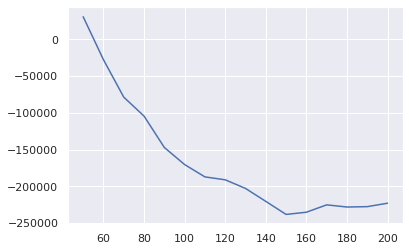

In [107]:
# AIC(데이터 셋에 대한 통계 모델의 상대적인 품질을 평가/ 낮을수록 좋음)를 사용해 GMM 성분 개수의 기준을 구한다
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [108]:
# 약 150개의 성분이 AIC를 최소화하는 것으로 알게되었다
# 이 모델을 사용해 데잍터에 적합시키고 모델이 수렴하는지 확인
gmm = GMM(150, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [124]:
data_new = gmm.sample(100, random_state=0)
data_new

# 새로운 숫자 구성
# PCA 객체의 가역 변환
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

TypeError: ignored

# KDE(커널 밀도 추정)
- 점당 하나의 가우스 성분으로 구성된 혼합을 사용해 근본적으로 비모수적 밀도 추정을 수행한다
- 1차원 경우 : 히스토그램이라는 밀도 추정 방식이 익숙
  - hist = plt.hist(x, bins=30, normed=True) : normed 매개변수를 이용하면 확률 밀도를 반영하는 정규화된 히스토그램을 얻을 수 있다
    - 문제점 : 구간에 따라 같은 데이터여도 다른 모습을 보일 수 있다
    - 해결 : 블록에 기여도 추가, 평활 함수를 사용

# KDE 실제 적용

In [127]:
# 구에 KED를 적용 : 남아메리카 포유류 2가지에 대한 관찰 내용 중 지리적 분포를 사용
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# 종 ID와 위치의 행렬 가져오기
latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T
                   
species = np.array([d.decode('ascii').startswith('micro') 
                      for d in data.train['species']], dtype='int')

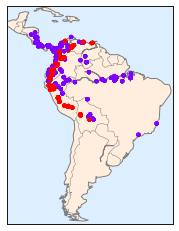

In [167]:
# basemap 툴킷을 사용해 남아메리카 지도 위에 관측된 위치를 표시
#!apt install proj-bin libproj-dev libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
#!pip install -U git+https://github.com/matplotlib/basemap.git

from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

#basemap으로 해안선 그리기
m = Basemap(projection='cyl', resolution='c', 
            llcrnrlat=ygrid.min(),urcrnrlat = ygrid.max(),
            llcrnrlon=xgrid.min(),urcrnrlon = xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# 위치 표시
m.scatter(latlon[:,1], latlon[:,0], zorder=3, c=species, cmap='rainbow', latlon=True, s=10) # zorder : 레이어 순서

# 종의 범위가 서로 겹쳐서 종의 밀도를 제대로 파악할 수 없다
# 해석이 가능하도록 매끄럽게 표현해야함

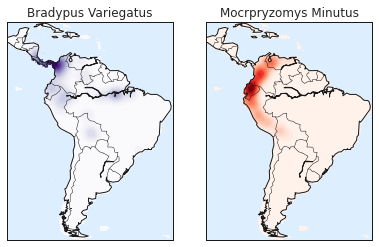

In [176]:
# 휘어진 표면에서 정확하게 거리를 나타낼 수 있는 
# haversine 거리 지표를 사용
from sklearn.neighbors import KernelDensity

# 등고선 플롯을 위한 데이터 그리드 설정
x, y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([y.ravel(), x.ravel()]).T # vstack : 합쳐준다(axis=0)
xy = np.radians(xy[land_mask])

# 두개의 플롯을 나란히 생성
fig, ax = plt.subplots(1,2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Mocrpryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
  axi.set_title(species_names[i])

  #Basemap으로 해안선 플로팅
  m = Basemap(projection='cyl', resolution='c', ax=axi,
            llcrnrlat=y.min(),urcrnrlat = y.max(),
            llcrnrlon=x.min(),urcrnrlon = x.max())
  m.drawmapboundary(fill_color='#DDEEFF')
  m.drawcoastlines()
  m.drawcountries()

  # 분포에 대한 구형 커널 밀도 추청
  kde = KernelDensity(bandwidth=0.03, metric='haversine')
  kde.fit(np.radians(latlon[species==i]))

  # 육지에 대해서만 평가 : -9999는 바다를 나타냄
  z = np.full(land_mask.shape[0], -9999.0)
  z[land_mask] = np.exp(kde.score_samples(xy))
  z = z.reshape(x.shape)

  # 밀도 등고선 그리기
  levels = np.linspace(0, z.max(), 25)
  axi.contourf(x, y, z, levels=levels, cmap=cmaps[i])